# Coursework Template

**Dependencies and imports**

This can take a minute...

In [6]:
# !pip install swig
# !pip install --upgrade rldurham

In [7]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


/home/billy/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/billy/Github/ReinforcementLearning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


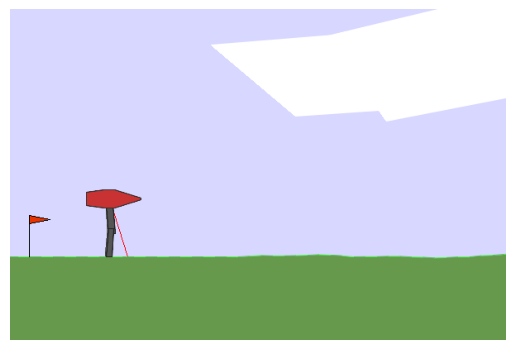

In [8]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

In [9]:
import numpy as np
import torch
import random
import gym
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
import pickle
import math


ENV = "BipedalWalker-v3"
MODEL_FILE = "./dqn_model"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
N_GAMES = 1000
MEM_SIZE = 1000000
BATCH_SIZE = 64
TARGET_UPDATE = 2
GAMMA = 0.99
EPSILON = 1
EPSILON_DEC = 1e-3
EPSILON_MIN = 0.05
LR = 1e-4

steps_taken = 0

class ExperienceReplay:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def __len__(self):
        return len(self.buffer)

    # Add a transition to the memory by basic SARNS convention. 
    def store_transition(self, state, action, reward, new_state, done):
        # If buffer is abuot to overflow, begin rewriting existing memory? 
        self.buffer.append((state, action, reward, new_state, done))

    # Sample only the memory that has been stored. Samples BATCH
    # amount of samples. 
    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*sample)
        states = torch.tensor(states).float().to(DEVICE)
        actions = torch.stack(actions).long().to(DEVICE)
        rewards = torch.from_numpy(np.array(rewards, dtype=np.float32).reshape(-1, 1)).to(DEVICE)
        next_states = torch.tensor(next_states).float().to(DEVICE)
        dones = torch.from_numpy(np.array(dones, dtype=np.uint8).reshape(-1, 1)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(QNetwork, self).__init__()
        # Make a simple 3 later linear network
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = self.l1(state)
        x = F.relu(x)
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x

class Agent():
    # Initialize the agent
    def __init__(self, state_space, action_space):
        self.memory = ExperienceReplay(MEM_SIZE)
        self.action_space = action_space
        self.main_model = QNetwork(state_space.shape[0], action_space.shape[0], action_space.high[0]).to(DEVICE)
        self.target_model = QNetwork(state_space.shape[0], action_space.shape[0], action_space.high[0]).to(DEVICE)
        self.optimizer = optim.Adam(self.main_model.parameters(), lr=LR)

        # Target model will be a copy of the main model and will not be trained
        self.target_model.load_state_dict(self.main_model.state_dict())
        self.target_model.eval()

    # Agent saves its experiences and learn
    def step(self, state, action, reward, new_state, done):
        # Stores the transition into Experience Replay
        self.memory.store_transition(state, action, reward, new_state, done)

        # Agent will only learn when there are enough experiences
        if len(self.memory) > BATCH_SIZE:
            self.learn()

    # Agent learns
    def learn(self):
        # Sample random minibatch of transitions from Experience Replay
        state, action, reward, new_state, done = self.memory.sample()
      
        # Computes Q(s_{curr},a') then chooses columns of actions that were taken for each batch
        q_eval = self.main_model(state)

        # Clone the model and use it to generate Q learning targets for the main model
        # Also predicts the max Q value for the next state
        q_next = self.target_model(new_state)

        # Q learning targets = r if next state is terminal or
        # Q learning targets = r + GAMMA*(Q(s_{next},a')) if next state is not terminal
        q_target = reward + GAMMA*(q_next) *(1-done)

        # Compute MSE loss
        loss = F.mse_loss(q_eval, q_target.unsqueeze(1))

        # Stochastic gradient descent on the loss function and does backpropragation
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.main_model.parameters():
            # Clip the error term to be between -1 and 1
            param.grad.data.clamp_(-1,1)
        self.optimizer.step()



    # Action chosen is either a random action or based on the Bellman Equation
    def choose_action(self, state):
        # EPSILON will esponentially decay
        global steps_taken 
        eps_threshold = EPSILON_MIN + (EPSILON - EPSILON_MIN)*math.exp(-1*steps_taken/EPSILON_DEC)
        steps_taken += 1

        # With probability EPSILON, select a random action
        if np.random.random() < eps_threshold:
            return torch.from_numpy(self.action_space.sample())
        # Otherwise select the action with the highest Q value
        else: 
            state = torch.FloatTensor(state.reshape(1,-1)).to(DEVICE)
            
            # action that maximizes Q*(s',a';THETA)  
            with torch.no_grad():
                return self.main_model(state).flatten().cpu().data

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

def replay_actions(env, actions):
    done = False
    state = env.reset()
    for action in actions:
        env.render()
        env.step(action)
    env.close()

def store_actions(actions, path):
    actions_file = open(path,'wb')
    pickle.dump(actions, actions_file)
    actions_file.close()

def load_actions(path):
    actions_file = open(path,'rb')
    actions = pickle.load(actions_file)
    actions_file.close()

    return actions

In [10]:
import numpy as np
import torch
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
import pickle
import math

# Device configuration - following rld recommendation for CPU training
DEVICE = torch.device("cpu")

# Hyperparameters
N_GAMES = 1000
MEM_SIZE = 1000000
BATCH_SIZE = 64
TARGET_UPDATE = 2
GAMMA = 0.99
EPSILON = 1
EPSILON_DEC = 1e-3
EPSILON_MIN = 0.05
LR = 1e-4

steps_taken = 0

class ExperienceReplay:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def __len__(self):
        return len(self.buffer)
    
    def store_transition(self, state, action, reward, new_state, done):
        # Convert numpy arrays to tensors before storing
        state = torch.FloatTensor(state).to(DEVICE)
        action = torch.FloatTensor(action).to(DEVICE)
        new_state = torch.FloatTensor(new_state).to(DEVICE)
        
        self.buffer.append((state, action, reward, new_state, done))
    
    def sample(self):
        sample = random.sample(self.buffer, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*sample)
        
        # Stack tensors for batch processing
        states = torch.stack(states).float()
        actions = torch.stack(actions)
        rewards = torch.FloatTensor(rewards).reshape(-1, 1)
        next_states = torch.stack(next_states).float()
        dones = torch.FloatTensor(dones).reshape(-1, 1)
        
        return states, actions, rewards, next_states, dones

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(QNetwork, self).__init__()
        
        # Increased network capacity for complex walking task
        self.l1 = nn.Linear(state_dim, 512)
        self.l2 = nn.Linear(512, 384)
        self.l3 = nn.Linear(384, 256)
        self.l4 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
        
        # Initialize weights using Xavier initialization
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.xavier_uniform_(self.l4.weight)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.max_action * torch.tanh(self.l4(x))
        return x

class Agent:
    def __init__(self, state_dim, action_dim, max_action):
        self.memory = ExperienceReplay(MEM_SIZE)
        self.action_dim = action_dim
        self.max_action = max_action
        
        # Initialize main and target networks
        self.main_model = QNetwork(state_dim, action_dim, max_action).to(DEVICE)
        self.target_model = QNetwork(state_dim, action_dim, max_action).to(DEVICE)
        
        # Use Adam optimizer with learning rate decay
        self.optimizer = optim.Adam(self.main_model.parameters(), lr=LR)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
                                                            factor=0.5, patience=20, 
                                                            verbose=True)
        
        # Initialize target network with main network's weights
        self.target_model.load_state_dict(self.main_model.state_dict())
        self.target_model.eval()

    def step(self, state, action, reward, new_state, done):
        # Store experience in replay buffer
        self.memory.store_transition(state, action, reward, new_state, done)
        
        # Learn if we have enough samples
        if len(self.memory) > BATCH_SIZE:
            return self.learn()
        return 0.0  # Return 0 loss if no learning occurred

    def learn(self):
        # Sample random minibatch of transitions
        states, actions, rewards, next_states, dones = self.memory.sample()
        
        # Get current Q values
        current_q_values = self.main_model(states)
        
        # Get next Q values from target network
        with torch.no_grad():
            next_q_values = self.target_model(next_states)
            next_q_values = next_q_values.max(1)[0].unsqueeze(1)
            
            # Compute target Q values
            target_q_values = rewards + (1 - dones) * GAMMA * next_q_values
        
        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, target_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.main_model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss.item()

    def choose_action(self, state):
        global steps_taken
        eps_threshold = EPSILON_MIN + (EPSILON - EPSILON_MIN) * math.exp(-1 * steps_taken / EPSILON_DEC)
        steps_taken += 1
        
        if random.random() < eps_threshold:
            # Random action
            return np.random.uniform(-self.max_action, self.max_action, size=self.action_dim)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            action = self.main_model(state).squeeze(0).numpy()
            return action

def train():
    # Create and setup environment
    env = rld.make("rldurham/Walker", render_mode="rgb_array")
    env = rld.Recorder(
        env,
        smoothing=10,
        video=True,
        video_folder="videos",
        video_prefix="xxxx00-agent-video",
        logs=True,
    )
    
    # Get environment information
    discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)
    
    # Initialize agent
    max_action = 1.0  # Actions are typically normalized to [-1, 1]
    agent = Agent(obs_dim, act_dim, max_action)
    
    # Training metrics
    best_reward = -float('inf')
    reward_history = []
    
    for episode in range(N_GAMES):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0
        episode_steps = 0
        
        while True:
            # Select action
            action = agent.choose_action(state)
            
            # Execute action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store experience and learn
            loss = agent.step(state, action, reward, next_state, done)
            
            episode_reward += reward
            episode_loss += loss
            episode_steps += 1
            
            if done:
                break
                
            state = next_state
        
        # Update target network periodically
        if episode % TARGET_UPDATE == 0:
            agent.target_model.load_state_dict(agent.main_model.state_dict())
        
        # Update learning rate based on performance
        agent.scheduler.step(episode_reward)
        
        # Save best model
        if episode_reward > best_reward:
            best_reward = episode_reward
            torch.save({
                'episode': episode,
                'model_state_dict': agent.main_model.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'reward': episode_reward,
            }, 'best_walker_model.pth')
        
        # Log progress
        reward_history.append(episode_reward)
        avg_reward = np.mean(reward_history[-100:])
        
        print(f"Episode {episode}")
        print(f"Total Reward: {episode_reward:.2f}")
        print(f"Average Reward (last 100): {avg_reward:.2f}")
        print(f"Best Reward: {best_reward:.2f}")
        print(f"Average Loss: {episode_loss/episode_steps:.6f}")
        print("----------------------------------------")
        
    env.close()
    return agent, reward_history


agent, history = train()

/home/billy/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


/tmp/ipykernel_90969/3689189370.py:126: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(current_q_values, target_q_values)


Episode 0
Total Reward: -112.13
Average Reward (last 100): -112.13
Best Reward: -112.13
Average Loss: 0.019048
----------------------------------------
Episode 1
Total Reward: -97.52
Average Reward (last 100): -104.83
Best Reward: -97.52
Average Loss: 0.833826
----------------------------------------
Episode 2
Total Reward: -100.91
Average Reward (last 100): -103.52
Best Reward: -97.52
Average Loss: 0.911177
----------------------------------------
Episode 3
Total Reward: -122.91
Average Reward (last 100): -108.37
Best Reward: -97.52
Average Loss: 0.915086
----------------------------------------
Episode 4
Total Reward: -123.48
Average Reward (last 100): -111.39
Best Reward: -97.52
Average Loss: 0.804985
----------------------------------------
Episode 5
Total Reward: -104.74
Average Reward (last 100): -110.29
Best Reward: -97.52
Average Loss: 0.741001
----------------------------------------
Episode 6
Total Reward: -102.05
Average Reward (last 100): -109.11
Best Reward: -97.52
Average

/home/billy/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Episode 89
Total Reward: -101.99
Average Reward (last 100): -102.46
Best Reward: -95.76
Average Loss: 1.708240
----------------------------------------
Episode 90
Total Reward: -103.56
Average Reward (last 100): -102.47
Best Reward: -95.76
Average Loss: 1.893739
----------------------------------------
Episode 91
Total Reward: -102.39
Average Reward (last 100): -102.47
Best Reward: -95.76
Average Loss: 1.664541
----------------------------------------
Episode 92
Total Reward: -103.30
Average Reward (last 100): -102.48
Best Reward: -95.76
Average Loss: 2.501974
----------------------------------------
Episode 93
Total Reward: -97.02
Average Reward (last 100): -102.42
Best Reward: -95.76
Average Loss: 1.610471
----------------------------------------
Episode 94
Total Reward: -103.85
Average Reward (last 100): -102.44
Best Reward: -95.76
Average Loss: 2.309167
----------------------------------------
Episode 95
Total Reward: -103.50
Average Reward (last 100): -102.45
Best Reward: -95.76
A

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [12]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
